In [23]:
#jupyter url: http://127.0.0.1:8888/tree?token=ecf2b449a6a9ef419978fb98f5824d2417333aa62eacd254

In [1]:
%cd /home/luzinsan/Documents/Obsidian/ML/Innopolis/material/1 semester/Machine Learning/Project/notebooks
!ls

/home/luzinsan/Documents/Obsidian/ML/Innopolis/material/1 semester/Machine Learning/Project/notebooks
data-profiling.ipynb  orders.ipynb


/home/luzinsan/.cache/pypoetry/virtualenvs/ml-venv-uqlfkjfM-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from category_encoders import BinaryEncoder, cat_boost
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Reading from database and prepare target feature

In [27]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///../F24.ML.Assignment.One.data.db')

with session_engine.connect() as conn: 
    original_orders = pd.read_sql_query(text('SELECT * FROM joined_table'), con=conn) 
    
original_orders.to_csv('../content/full_orders_df.csv', index=False)
original_orders

In [4]:
date_cols = ['date_create', 'order_start_prepare', 'order_ready'] 
for col_name in date_cols:
    original_orders[col_name] = pd.to_datetime(original_orders[col_name], format='mixed')
original_orders['order_pickup'] = pd.to_datetime(original_orders['order_pickup'], dayfirst=True)

orders = original_orders.copy() 
orders 

In [26]:
print("Observations with None in 'date_create' and 'order_start_prepare': ", (orders['date_create'].isnull() \
                                                                              & orders['order_start_prepare'].isnull()).sum(), 
      "\nWill be drop in the next line")
orders = orders[~(orders['date_create'].isnull() & orders['order_start_prepare'].isnull())]
orders.shape

In [30]:
def impute_dates_by_store(x):
    diff_date = x['order_start_prepare'] - x['date_create']
    mean_diff = diff_date[diff_date > pd.to_timedelta("0 days")].mean()
    x.loc[x['order_start_prepare'].isnull(), 'order_start_prepare'] = x.loc[x['order_start_prepare'].isnull(), 'date_create'] + mean_diff
    x.loc[x['date_create'].isnull(), 'date_create'] = x.loc[x['date_create'].isnull(), 'order_start_prepare'] - mean_diff

    diff_date = x['order_pickup'] - x['order_ready']
    mean_diff = diff_date[diff_date > pd.to_timedelta("0 days")].mean()
    x.loc[x['order_pickup'].isnull(), 'order_pickup'] = x.loc[x['order_pickup'].isnull(), 'order_ready'] + mean_diff
    x.loc[x['order_ready'].isnull(), 'order_ready'] = x.loc[x['order_ready'].isnull(), 'order_pickup'] - mean_diff
    return x

orders.loc[:,['date_create','order_start_prepare','order_ready','order_pickup']] = orders.groupby("store_id")\
        .apply(lambda x: impute_dates_by_store(x))\
        .reset_index(allow_duplicates=True)\
        .set_index('level_1')[['date_create','order_start_prepare','order_ready','order_pickup']]


In [31]:
orders.loc[:, 'actual_prep_time'] = (orders['order_ready'] - orders['order_start_prepare']).dt.total_seconds() /60

anomaly_diff_mask = (orders['actual_prep_time'] < 0) | orders['actual_prep_time'].isnull() 
print(orders.loc[anomaly_diff_mask].shape)
orders = orders.loc[~anomaly_diff_mask]

In [8]:
orders['on_time'] = np.where(abs(orders['planned_prep_time'] - orders['actual_prep_time']) <= 5, 1, 0)

In [32]:
orders = orders.drop(columns=['order_id','order_ready','order_pickup'])

In [34]:
orders.to_csv('../content/orders_with_target.csv', index=False)

# EDA

In [4]:
orders = pd.read_csv('../content/orders_with_target.csv', parse_dates=['date_create','order_start_prepare'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515064 entries, 0 to 515063
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   store_id             515064 non-null  int64         
 1   products             515064 non-null  int64         
 2   order_price          500179 non-null  float64       
 3   profit               463932 non-null  float64       
 4   delivery_distance    515064 non-null  int64         
 5   date_create          515064 non-null  object        
 6   order_start_prepare  515064 non-null  datetime64[ns]
 7   planned_prep_time    515063 non-null  float64       
 8   region_id            515064 non-null  int64         
 9   status_id            515064 non-null  object        
 10  actual_prep_time     515064 non-null  float64       
 11  on_time              515064 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(2)
memory usage: 47.2

In [5]:
numerical = ['products','order_price','profit','delivery_distance','actual_prep_time']

## Uni-variate analysis

In [14]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(orders["products"], stat='density', 
			 kde=True, bins=orders.products.max(), discrete=True,
             ax=axes[0])
sns.histplot(orders[["order_price","profit"]], 
             stat='density', 
			 kde=True,
             bins=35,
             ax=axes[1])

In [15]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(orders[["delivery_distance"]], 
             stat='density', 
			 kde=True,
             bins=35, ax=axes[0])
sns.boxplot(x="delivery_distance", data=orders, ax=axes[1])

Here we see that `delivery_distance` has outliers

In [16]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(orders[["planned_prep_time"]], 
             stat='density', 
			 kde=True,
             bins=35, ax=axes[0])
sns.boxplot(x="planned_prep_time", data=orders, ax=axes[1])

In [17]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(orders[["actual_prep_time"]], 
             stat='density', 
			 kde=True,
            #  bins=35
            ax=axes[0]
             )
sns.boxplot(x="actual_prep_time", data=orders, ax=axes[1])

## Categorical and binary features

In [96]:
_, axes = plt.subplots(1,2, figsize=(18,4))
orders['region_id'].value_counts().plot(kind='bar',
                                        yticks=orders['region_id'].value_counts().values[::4],
                                        title='region_id',
                                        ax=axes[0])
orders['status_id'].value_counts().plot(kind='bar', logy=True, title='status_id', ax=axes[1])


In [102]:
orders['store_id'].value_counts()

In [29]:
pie_data = orders.value_counts('on_time')
plt.pie(pie_data, labels=pie_data.index.map({0:'Late', 1:"On time"}), autopct='%0.01f%%')

## Multi-dimentional analysis

In [39]:
orders['original_price'] = orders['order_price'] + orders['profit']

In [41]:
corr_matrix = orders[['products','order_price','profit','original_price','delivery_distance','actual_prep_time']].corr()
sns.heatmap(corr_matrix, annot=True)

In [14]:
sns.relplot(orders, 
            kind="scatter",
            x='order_price', y='profit', 
            hue='actual_prep_time', size='actual_prep_time', sizes=(20, 200), hue_norm=(0, 500),
            col="status_id")

In [31]:
%config InlineBackend.figure_format = 'png'
sns.pairplot(orders.select_dtypes('number'))

In [6]:
orders_without_outls = orders.copy()
num_dropped = 0
for feature in numerical:
    upper_quantile = orders[feature].quantile(q=0.99)
    print(f'99% quantile of "{feature}": {upper_quantile:.001f}')
    mask_outliers = orders[feature] > upper_quantile
    print(f"Percent of outliers from entire dataset: {mask_outliers.sum() / len(orders) * 100: 0.001f}%")
    print(f"Percent of outliers from current dataset: {mask_outliers.sum() / len(orders_without_outls) * 100 : .001f}%")
    print("Delete ", mask_outliers.sum(), " observations.\n")
    num_dropped += mask_outliers.sum()
    orders_without_outls = orders_without_outls[~mask_outliers]
print('Thus, was dropped: ', num_dropped)
orders_without_outls.shape

In [7]:
ncols = 3
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(14, 6))
for idx, feat in enumerate(numerical):
	ax = axes[idx // ncols, idx % ncols]
	sns.boxplot(x='on_time', y=feat, data=orders_without_outls, ax=ax)
	ax.set_xlabel('on_time')
	ax.set_ylabel(feat)

fig.tight_layout()

In [8]:
corr_matrix = orders_without_outls[['products','order_price','profit','delivery_distance','actual_prep_time']].corr()
sns.heatmap(corr_matrix, annot=True)

In [9]:
sns.catplot(
    x="on_time",
    y="products",
    col="region_id",
    data=orders_without_outls,
    kind="box",
    col_wrap=4,
    height=3,
    aspect=0.8,
);

## PCA

In [ ]:
# mean_vector = np.mean(X_train, axis=0)
# data_centered = X_train - mean_vector
# data_centered

In [ ]:
# # this is to check your solution
# from sklearn.decomposition import PCA
# pca = PCA(n_components=1)
# x_PCA = pca.fit_transform(X_train)
# plt.plot(x_PCA, np.zeros(len(x_PCA)), '.', color="red", label="Projected")

# Preprocess the data

In [3]:
data_features = ['date_create', 'order_start_prepare']
numerical = ['products','order_price','profit','delivery_distance','actual_prep_time']
orders = pd.read_csv('../content/orders_with_target.csv', parse_dates=['date_create','order_start_prepare'])

for col_name in data_features:
    orders[col_name] = pd.to_datetime(orders[col_name], format='mixed')

orders.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515064 entries, 0 to 515063
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   store_id             515064 non-null  int64         
 1   products             515064 non-null  int64         
 2   order_price          500179 non-null  float64       
 3   profit               463932 non-null  float64       
 4   delivery_distance    515064 non-null  int64         
 5   date_create          515064 non-null  datetime64[ns]
 6   order_start_prepare  515064 non-null  datetime64[ns]
 7   planned_prep_time    515063 non-null  float64       
 8   region_id            515064 non-null  int64         
 9   status_id            515064 non-null  object        
 10  actual_prep_time     515064 non-null  float64       
 11  on_time              515064 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(5), object(1)
memory usage: 47.2

In [4]:
orders_without_outls = orders.copy()
num_dropped = 0
for feature in numerical:
    upper_quantile = orders[feature].quantile(q=0.99)
    print(f'99% quantile of "{feature}": {upper_quantile:.001f}')
    mask_outliers = orders[feature] > upper_quantile
    print(f"Percent of outliers from entire dataset: {mask_outliers.sum() / len(orders) * 100: 0.001f}%")
    print(f"Percent of outliers from current dataset: {mask_outliers.sum() / len(orders_without_outls) * 100 : .001f}%")
    print("Delete ", mask_outliers.sum(), " observations.\n")
    num_dropped += mask_outliers.sum()
    orders_without_outls = orders_without_outls[~mask_outliers]
print('Thus, was dropped: ', num_dropped)
orders_without_outls.shape

99% quantile of "products": 8.0
Percent of outliers from entire dataset:  0.6%
Percent of outliers from current dataset:  0.6%
Delete  3069  observations.

99% quantile of "order_price": 319.9
Percent of outliers from entire dataset:  1.0%
Percent of outliers from current dataset:  1.0%
Delete  4948  observations.

99% quantile of "profit": 207.0
Percent of outliers from entire dataset:  0.9%
Percent of outliers from current dataset:  0.9%
Delete  4640  observations.

99% quantile of "delivery_distance": 14682.4
Percent of outliers from entire dataset:  1.0%
Percent of outliers from current dataset:  1.0%
Delete  5151  observations.

99% quantile of "actual_prep_time": 55.8
Percent of outliers from entire dataset:  1.0%
Percent of outliers from current dataset:  1.0%
Delete  5148  observations.

Thus, was dropped:  22956


(495971, 12)

In [5]:
df = orders_without_outls.copy()
df.columns

Index(['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'date_create', 'order_start_prepare', 'planned_prep_time', 'region_id',
       'status_id', 'actual_prep_time', 'on_time'],
      dtype='object')

In [6]:
target = ['actual_prep_time','on_time']
cat_features = ['store_id','region_id','status_id']
numeric_features = ['products', 'order_price', 'profit', 'delivery_distance']

df[cat_features] = df[cat_features].astype('object') 

In [7]:
def encode_cyclical_feat(data: pd.DataFrame, col: pd.Series, col_name: str):
    data[col_name + '_sin'] = np.sin(2 * np.pi * col/col.max())
    data[col_name + '_cos'] = np.cos(2 * np.pi * col/col.max())
    return data

for col_name in data_features:
    df = encode_cyclical_feat(df, df[col_name].dt.month, col_name + '_month')
    df = encode_cyclical_feat(df, df[col_name].dt.day, col_name + '_day')
    df = encode_cyclical_feat(df, df[col_name].dt.weekday, col_name + '_weekday')
    df = encode_cyclical_feat(df, df[col_name].dt.hour, col_name + '_hour')
    df = encode_cyclical_feat(df, df[col_name].dt.minute, col_name + '_minute')
    df = df.drop(columns=col_name)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target], 
                                                    train_size=0.7)

###################################### Imputting #####################################
from sklearn.impute import SimpleImputer
col_imputing = ['order_price','profit']
imputer = SimpleImputer()
X_train[col_imputing] = pd.DataFrame(imputer.fit_transform(X_train[col_imputing]), columns=col_imputing, index=X_train.index)
X_test[col_imputing] = pd.DataFrame(imputer.transform(X_test[col_imputing]), columns=col_imputing, index=X_test.index)


###################################### Encoding #####################################
encoder = cat_boost.CatBoostEncoder(cols=cat_features)
X_train = encoder.fit_transform(X_train, y_train.iloc[:,0])
X_test = encoder.transform(X_test, y_test.iloc[:,0])

##################################### Scaling #####################################
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())


In [9]:
all_features = ['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'region_id', 'status_id', 
       'date_create_month_sin', 'date_create_month_cos', 
       'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos',
       'planned_prep_time', 'actual_prep_time','on_time']

# Regression

In [10]:
target = 'actual_prep_time'
y_train, y_test = y_train[target], y_test[target]

## Experiment #1

In [11]:
feature_selected = ['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'region_id', 'status_id', 
       'date_create_month_sin', 'date_create_month_cos', 
       'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos',
       ]
X_train_reg = X_train[feature_selected]
X_test_reg = X_test[feature_selected]

Model intercept : 6.202109978572041
Model coefficient : [ 36.06337394   6.05606012   5.83075355   1.25141294   3.76386645
  -2.76500335  -7.38716096  -1.78985526  15.74689259  -6.4238216
  -4.82377124   1.08971945   1.79260424  -1.04381002  12.89913387
  -0.43639376   0.14020414   1.79164567 -15.59081185   6.33248882
   4.75745085  -1.33651604  -1.98059842   1.49295645 -13.28037507
   0.54320757  -0.16357529]
Mean Absolute Error: 6.49066729661905
Mean Squared Error: 71.30964767615697
Root Mean Squared Error: 8.444503992311033
R^2: 0.32226892003673


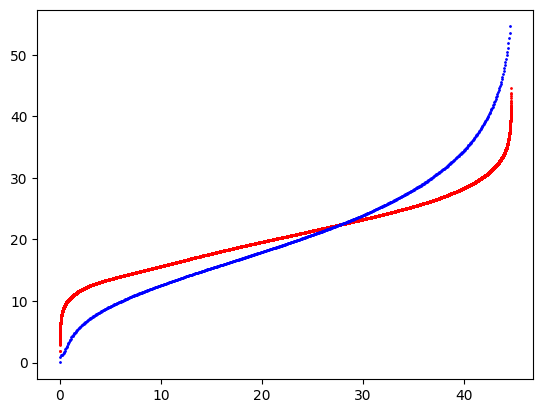

In [12]:
# With CatBoost Encoder and MinMax Scaler
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train_reg, y_train)
print(f"Model intercept : {regressor.intercept_}")
print(f"Model coefficient : {regressor.coef_}")

y_pred = regressor.predict(X_test_reg)
eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# With CatBoost Encoder and Robust Scaler
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

In [25]:
from sklearn.linear_model import Lasso
alpha = 0.0001
lasso = Lasso(alpha, random_state=42)
lasso.fit(X_train_reg, y_train)

y_pred = lasso.predict(X_test_reg)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

importance_features = abs(pd.Series(lasso.coef_, lasso.feature_names_in_)).sort_values()
importance_features = importance_features[importance_features > 0]
importance_features

Mean Absolute Error: 6.490747428304869
Mean Squared Error: 71.36576466181796
Root Mean Squared Error: 8.447826031697028
R^2: 0.3217355809089163


order_start_prepare_minute_sin      0.128249
date_create_weekday_cos             0.128608
date_create_month_cos               0.141542
order_start_prepare_weekday_sin     0.241771
order_start_prepare_weekday_cos     0.312507
order_start_prepare_hour_cos        0.373472
order_start_prepare_hour_sin        0.603560
profit                              1.250341
region_id                           2.754209
delivery_distance                   3.720076
order_price                         5.813190
products                            6.053334
store_id                           36.032126
dtype: float64

## Experiment #2

In [26]:
X_train_reg = X_train[importance_features.index]
X_test_reg = X_test[importance_features.index]

Model intercept : 1.239397485175818
order_start_prepare_minute_sin      0.129190
date_create_month_cos               0.142388
order_start_prepare_weekday_sin     0.243858
order_start_prepare_hour_cos        0.374072
order_start_prepare_hour_sin        0.605799
profit                              1.252441
date_create_weekday_cos             1.853264
order_start_prepare_weekday_cos     2.037174
region_id                           2.770511
delivery_distance                   3.722906
order_price                         5.815207
products                            6.054531
store_id                           36.038783
dtype: float64 


Mean Absolute Error: 6.490790462873986
Mean Squared Error: 71.36598619765124
Root Mean Squared Error: 8.447839143689423
R^2: 0.3217334754193447


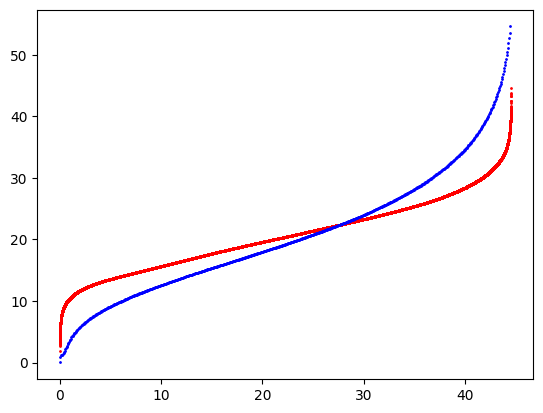

In [27]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train_reg, y_train)
print(f"Model intercept : {regressor.intercept_}")
print(abs(pd.Series(regressor.coef_, regressor.feature_names_in_)).sort_values(), '\n\n')

y_pred = regressor.predict(X_test_reg)
eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

## Ridge

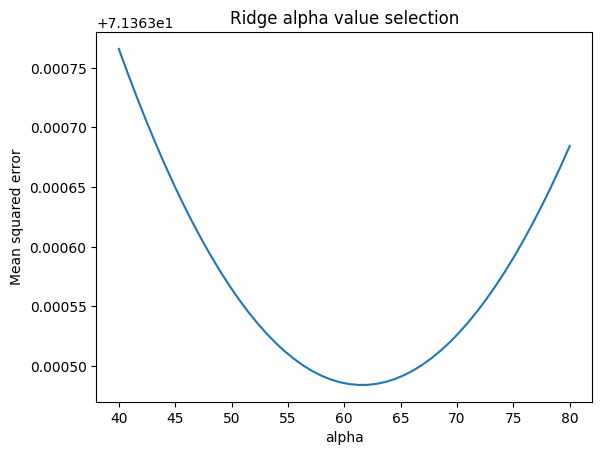

Best value of alpha: 61.224489795918366
Mean Absolute Error: 6.492051806398459
Mean Squared Error: 71.36348426720707
Root Mean Squared Error: 8.447691061302317
R^2: 0.3217572539132396


order_start_prepare_minute_sin      0.128624
date_create_month_cos               0.137473
order_start_prepare_weekday_sin     0.243575
order_start_prepare_hour_cos        0.373209
date_create_weekday_cos             0.414839
order_start_prepare_weekday_cos     0.597635
order_start_prepare_hour_sin        0.601529
profit                              1.296924
region_id                           2.556757
delivery_distance                   3.706126
order_price                         5.811238
products                            6.028164
store_id                           35.695144
dtype: float64

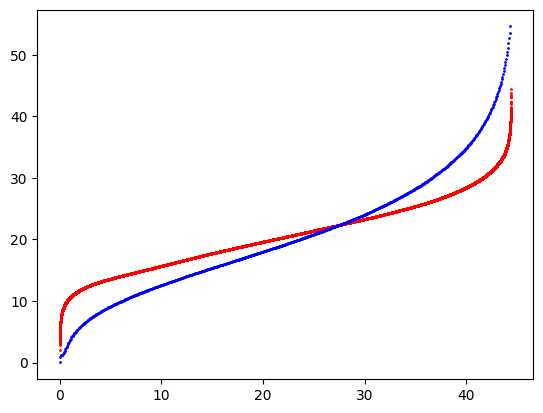

In [28]:
from sklearn.linear_model import Ridge
alphas = np.linspace(40, 80, 50)
losses = []
for alpha in alphas:
    ridge = Ridge(alpha, random_state=42)
    ridge.fit(X_train_reg, y_train)
    losses.append(metrics.mean_squared_error(y_test, ridge.predict(X_test_reg)))
   
    
plt.plot(alphas, losses)
plt.title("Ridge alpha value selection")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.show()

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha:", best_alpha)

alpha = best_alpha
ridge = Ridge(alpha, random_state=42)
ridge.fit(X_train_reg, y_train)
y_pred = ridge.predict(X_test_reg)


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')


abs(pd.Series(ridge.coef_, ridge.feature_names_in_)).sort_values()

## Polynomial

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

Polynomial degree:  3
Mean Absolute Error: 39744014.765075885
Mean Squared Error: 2.1574133714545567e+20
Root Mean Squared Error: 14688135931.6101
R^2: -2.0493101665841554e+18


,Actual,Predicted
0,13.483333,20.181152
1,13.183333,21.603516
2,20.250000,21.681641
3,24.333333,18.785645
4,28.316667,20.641113
...,...,...
148787,13.466667,15.51123
148788,30.350000,14.466309
148789,10.300000,15.334229
148790,28.483333,28.933594


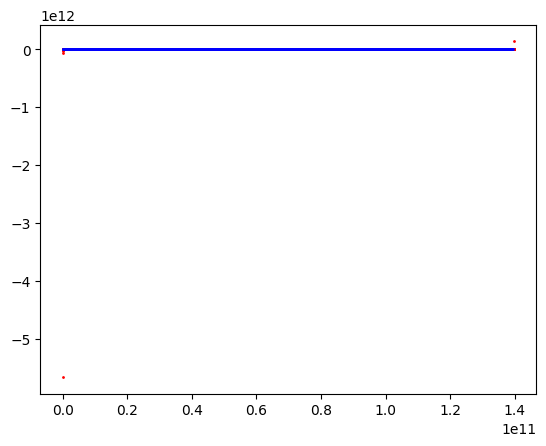

In [34]:
degrees = [3]


for i in degrees:
    polynomial_features = PolynomialFeatures(degree=i)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train_reg, y_train.to_frame())

    y_pred = pipeline.predict(X_test_reg)
    print("Polynomial degree: ", i)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R^2:', metrics.r2_score(y_test, y_pred))

eval_df = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': pd.Series(y_pred.tolist()).explode()})
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')
eval_df

In [40]:
pd.Series(y_pred.tolist()).explode().astype('float').describe()

count    1.487920e+05
mean    -3.786643e+07
std      1.468814e+10
min     -5.663521e+12
25%      1.600879e+01
50%      2.027429e+01
75%      2.453577e+01
max      1.396825e+11
dtype: float64

## Support vector regression

In [29]:
feature_selected = [
    'delivery_distance','order_price',
    'products','store_id'
    ]
X_train_reg = X_train[feature_selected]
X_test_reg = X_test[feature_selected]

In [31]:
X_train_reg_svr = X_train_reg.sample(50)
X_train_reg_svr = X_test_reg.sample(50)

In [32]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf',C=20, gamma=1)
svr.fit(X_train_reg, y_train)

In [ ]:
print("Support vectors: ", svr.support_vectors_) # get support vectors
print("indices of support vectors: ", svr.support_) # get indices of support vectors
print("number of support vectors for each class: ", svr.n_support_) # get number of support vectors for each class

## Neural Network

In [ ]:
from torch import nn

# Classification

In [83]:
df = pd.read_csv('../content/orders_with_target.csv')
df.columns

In [67]:
df.info()

In [61]:
# experiment #1
feature_selected = ['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'region_id', 'date_create_month_sin',
       'date_create_month_cos', 'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos', 'on_time']
df = df[feature_selected]

In [85]:
# experiment #2
feature_selected = ['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'region_id', 
       'date_create_hour_cos',
       'order_start_prepare_hour_cos',
       'on_time']
df = df[feature_selected]

In [86]:
target = 'on_time'
cat_features = ['store_id','region_id']
numeric_features = df.columns.difference(cat_features + [target])
df[cat_features] = df[cat_features].astype('object') 

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target], 
                                                    train_size=0.7)

# Fill missing values
from sklearn.impute import SimpleImputer
col_imputing = ['order_price','profit']
imputer = SimpleImputer()
X_train[col_imputing] = pd.DataFrame(imputer.fit_transform(X_train[col_imputing]), columns=col_imputing, index=X_train.index)
X_test[col_imputing] = pd.DataFrame(imputer.transform(X_test[col_imputing]), columns=col_imputing, index=X_test.index)


encoder = cat_boost.CatBoostEncoder(cols=cat_features)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test, y_test)

scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())

In [88]:
# Experiment #2
from sklearn.linear_model import LogisticRegression

# fit Logistic Regression
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

# Logistic Regression Coefficients
print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(X_train.columns), clf.coef_[0])], sep='\n')

In [89]:
# TODO: calculate metrics for each threshold above and plot the result as below.
# thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
thresholds = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
pred_proba = clf.predict_proba(X_test)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr)) # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr)) # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr)) # recall
    
plt.plot(thresholds, results[0], label = 'accuracy')   
plt.plot(thresholds, results[1], label = 'precision')   
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

In [91]:
# Select the optimal prediction threshold
optimal_thresholds = 0.4

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


pred_proba = clf.predict_proba(X_test)
y_pred = np.where(pred_proba[:, 1] > optimal_thresholds, 1, 0)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, 
                    #   normalize='true'
                      )
ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred)))
print('Testing f1_score = {}'.format(metrics.f1_score(y_test, y_pred)))